Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV] END contamination=0.1, max_features=1, max_samples=100, n_estimators=100; total time=   3.9s
[CV] END contamination=0.1, max_features=1, max_samples=100, n_estimators=100; total time=   4.2s
[CV] END contamination=0.1, max_features=1, max_samples=100, n_estimators=100; total time=   2.7s
[CV] END contamination=0.1, max_features=1, max_samples=100, n_estimators=100; total time=   2.9s
[CV] END contamination=0.1, max_features=1, max_samples=100, n_estimators=100; total time=   2.4s
[CV] END contamination=0.05, max_features=1, max_samples=auto, n_estimators=100; total time=   2.5s
[CV] END contamination=0.05, max_features=1, max_samples=auto, n_estimators=100; total time=   2.5s
[CV] END contamination=0.05, max_features=1, max_samples=auto, n_estimators=100; total time=   3.0s
[CV] END contamination=0.05, max_features=1, max_samples=auto, n_estimators=100; total time=   3.1s
[CV] END contamination=0.05, max_features=1, max_

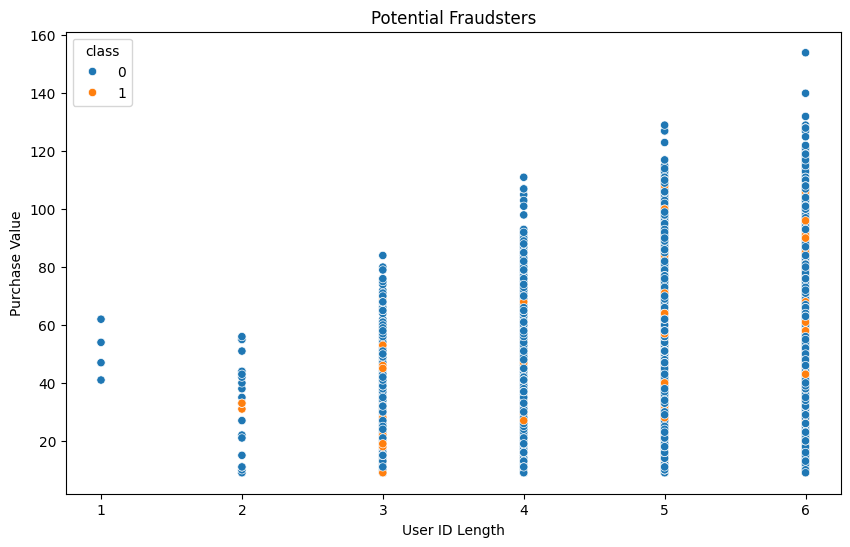


User ID Length Analysis:
Summary Statistics:
count    151112.000000
mean          5.724059
std           0.510414
min           1.000000
25%           6.000000
50%           6.000000
75%           6.000000
max           6.000000
Name: user_id_length, dtype: float64

Correlation with Target:
                user_id_length   class
user_id_length          1.0000 -0.0029
class                  -0.0029  1.0000


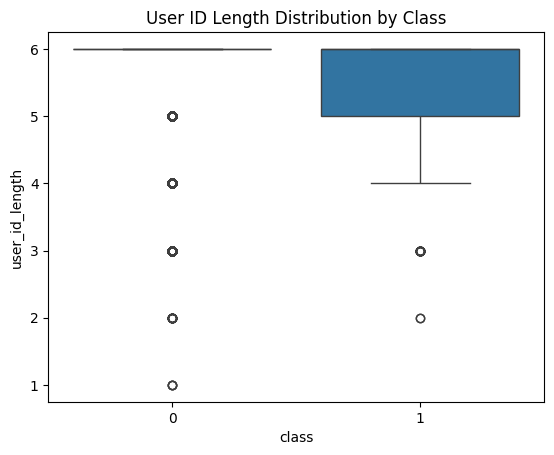


Purchase Value Analysis:
Summary Statistics:
count    151112.000000
mean         36.935372
std          18.322762
min           9.000000
25%          22.000000
50%          35.000000
75%          49.000000
max         154.000000
Name: purchase_value, dtype: float64


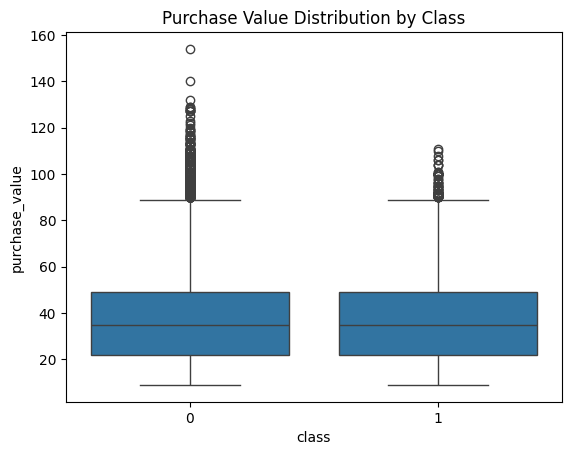


Country Encoding Analysis:
Frequency of Transactions by Country:
171    58049
172    21966
36     12038
84      7306
170     4490
       ...  
114        1
175        1
49         1
122        1
68         1
Name: country_encoded, Length: 182, dtype: int64

Fraudulent Transactions by Country:
171    5551
172    1883
36     1043
84      715
170     477
       ... 
102       1
146       1
166       1
100       1
106       1
Name: country_encoded, Length: 110, dtype: int64


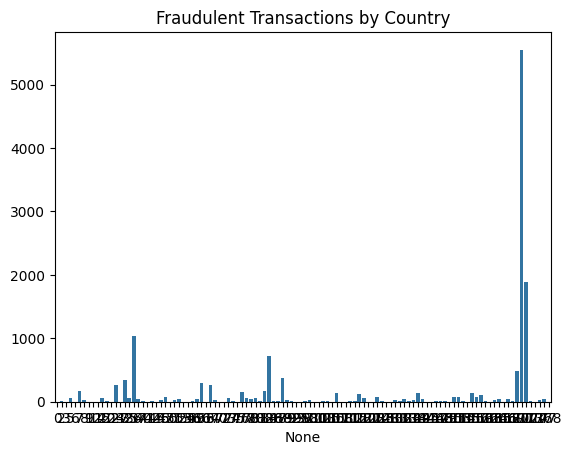


Correlation Analysis:
                 user_id_length  purchase_value  country_encoded     class
user_id_length         1.000000        0.002339         0.001342 -0.002900
purchase_value         0.002339        1.000000        -0.003412  0.001011
country_encoded        0.001342       -0.003412         1.000000 -0.001160
class                 -0.002900        0.001011        -0.001160  1.000000


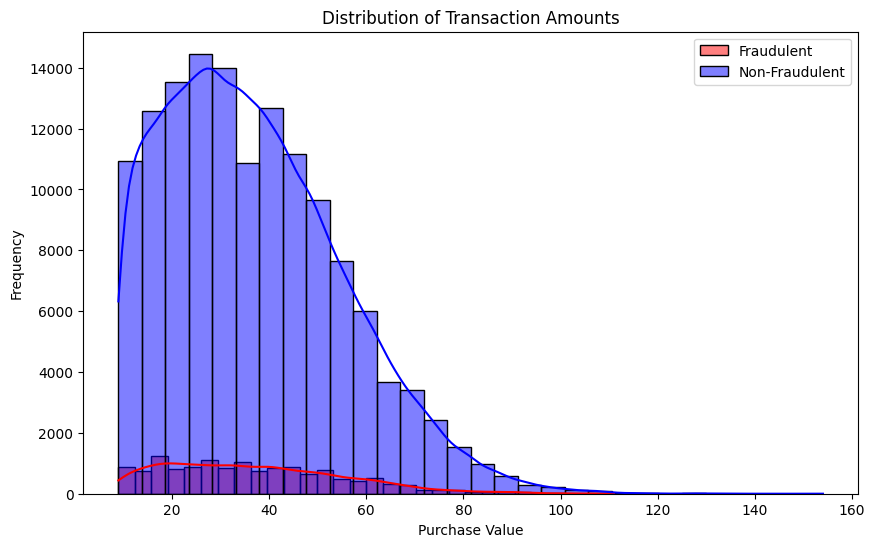

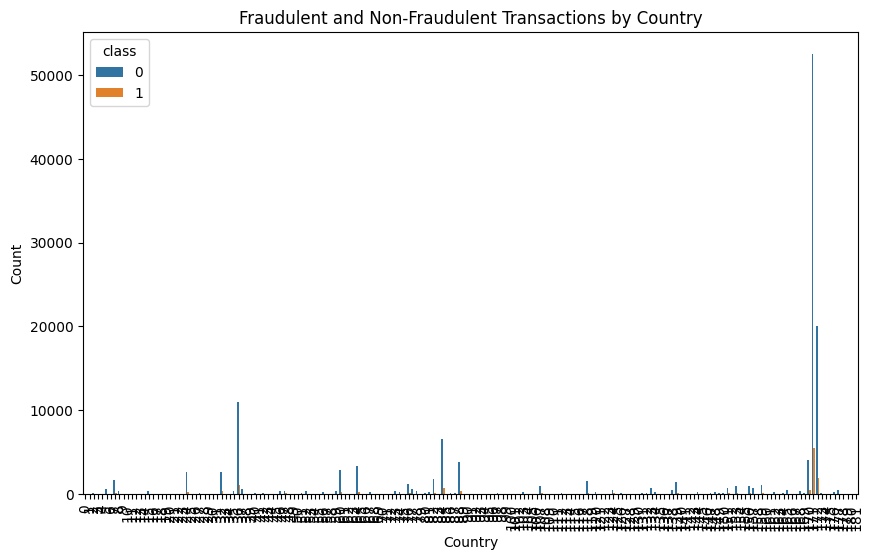

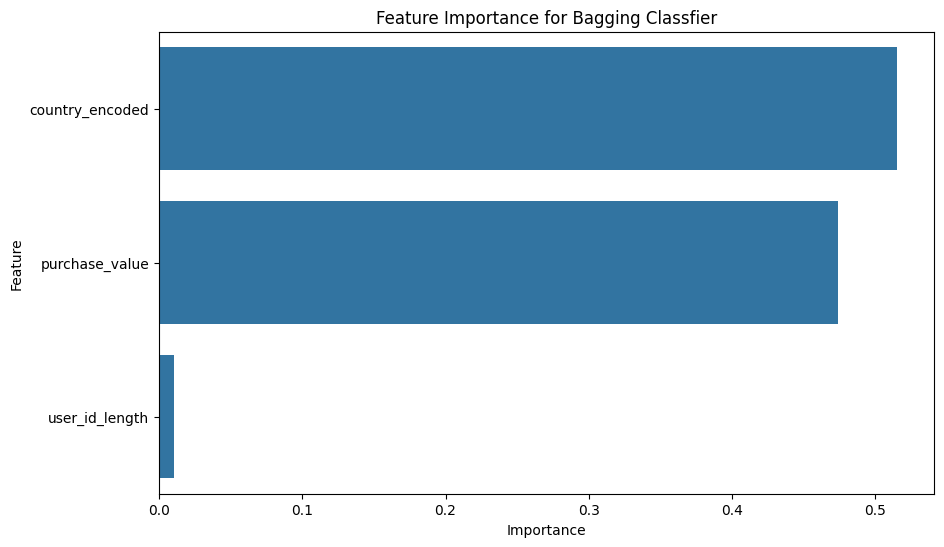

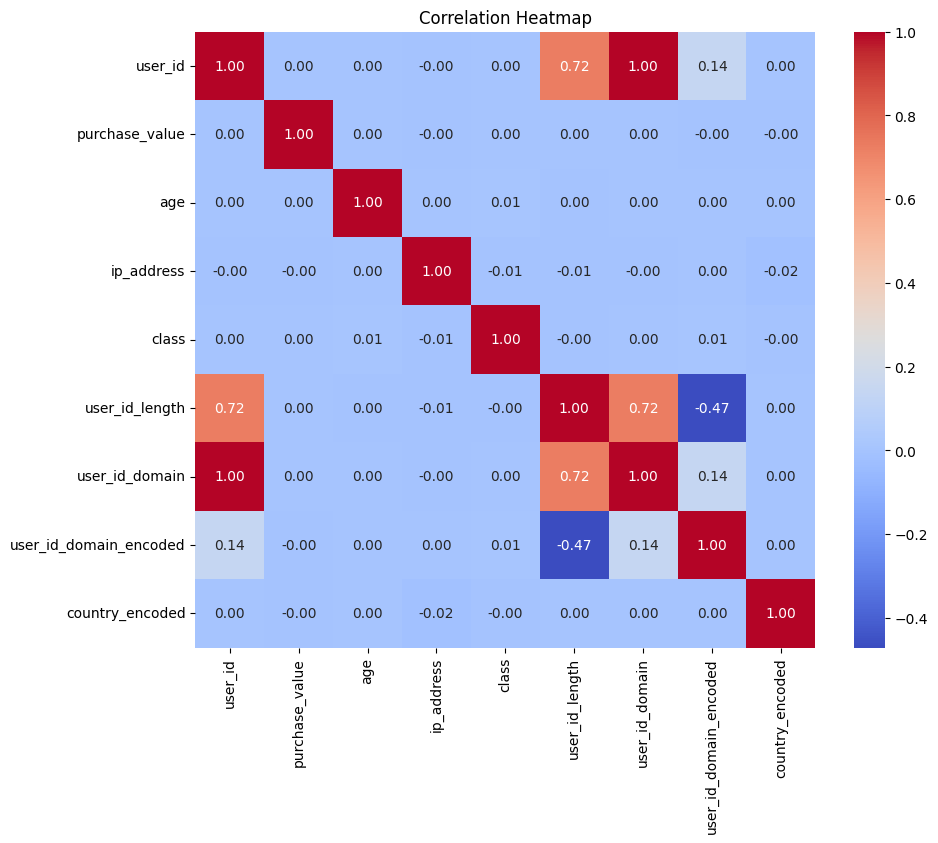

Models and other data saved successfully.


In [1]:
import joblib
import pandas as pd
import numpy as np
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier, IsolationForest
from sklearn.neighbors import LocalOutlierFactor
from sklearn.model_selection import RandomizedSearchCV, StratifiedKFold  # Import StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report, roc_curve, auc
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
import warnings
import matplotlib.pyplot as plt  # Import matplotlib for plotting
import seaborn as sns  # Import seaborn for visualization
warnings.filterwarnings("ignore")
# Load dataset
data = pd.read_csv(r'/content/modified_dataset.csv')

# Step 1: Anomaly Detection using Isolation Forest and Local Outlier Factor (LOF)

# Features for anomaly detection
X_anomaly = data[['user_id_length', 'purchase_value', 'country_encoded']]

# Isolation Forest
isolation_forest = IsolationForest(random_state=42)
isolation_forest_param_grid = {
    'n_estimators': [100, 200, 300],
    'max_samples': ['auto', 100, 200],
    'contamination': [0.05, 0.1, 0.2],
    'max_features': [1, 2, 3]
}
isolation_forest_random_search = RandomizedSearchCV(isolation_forest, isolation_forest_param_grid, n_iter=10, cv=5, verbose=2, random_state=42, scoring='accuracy')
isolation_forest_random_search.fit(X_anomaly)
best_isolation_forest = isolation_forest_random_search.best_estimator_
anomaly_preds_if = best_isolation_forest.predict(X_anomaly)
anomaly_indices_if = anomaly_preds_if == -1  # Anomalies detected by Isolation Forest

# LOF
lof = LocalOutlierFactor()
lof_param_grid = {
    'n_neighbors': [20, 30, 40],
    'contamination': [0.05, 0.1, 0.2]
}
lof_random_search = RandomizedSearchCV(lof, lof_param_grid, n_iter=5, cv=5, verbose=2, random_state=42, scoring='accuracy')
lof_random_search.fit(X_anomaly)
best_lof = lof_random_search.best_estimator_
anomaly_preds_lof = best_lof.fit_predict(X_anomaly)
anomaly_indices_lof = anomaly_preds_lof == -1  # Anomalies detected by LOF

# Combine anomaly detections
anomaly_indices_combined = np.logical_or(anomaly_indices_if, anomaly_indices_lof)

# Print anomaly detection results
print("\nAnomaly Detection Results:")
print("Number of Anomalies (Isolation Forest):", anomaly_indices_if.sum())
print("Number of Anomalies (LOF):", anomaly_indices_lof.sum())
print("Number of Anomalies (Combined):", anomaly_indices_combined.sum())

# Step 2: Flagging Potential Fraudsters

# Filter potential fraudsters
potential_fraudsters = data[anomaly_indices_combined | (data['country_encoded'] == 'specific_country')]
print("\nPotential Fraudsters:")
print(potential_fraudsters)

# Suppress warnings
warnings.filterwarnings("ignore")

# Step 3: Classifier Training and Evaluation

# Features and target variable
X = data[['user_id_length', 'purchase_value', 'country_encoded']]
y = data['class']

# Standardize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Define base classifiers
random_forest = RandomForestClassifier()
logistic_regression = LogisticRegression()
knn = KNeighborsClassifier()
decision_tree = DecisionTreeClassifier()
mlp_classifier = MLPClassifier()

# Define hyperparameter grids for each classifier
random_forest_param_grid = {
    'n_estimators': [10, 50, 100],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['auto', 'sqrt', 'log2']
}

logistic_regression_param_grid = {
    'C': [0.1, 1, 10],
    'penalty': ['l1', 'l2']
}

knn_param_grid = {
    'n_neighbors': [3, 5, 10],
    'weights': ['uniform', 'distance'],
    'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute']
}

decision_tree_param_grid = {
    'criterion': ['gini', 'entropy'],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['auto', 'sqrt', 'log2']
}

mlp_param_grid = {
    'hidden_layer_sizes': [(50,), (100,), (150,)],
    'activation': ['identity', 'logistic', 'tanh', 'relu'],
    'solver': ['lbfgs', 'sgd', 'adam'],
    'alpha': [0.0001, 0.001, 0.01],
    'max_iter': [200, 500, 1000]
}

# Perform Randomized Search for each classifier
random_forest_random_search = RandomizedSearchCV(random_forest, random_forest_param_grid, n_iter=10, cv=5, verbose=2, random_state=42)
logistic_regression_random_search = RandomizedSearchCV(logistic_regression, logistic_regression_param_grid, n_iter=10, cv=5, verbose=2, random_state=42)
knn_random_search = RandomizedSearchCV(knn, knn_param_grid, n_iter=10, cv=5, verbose=2, random_state=42)
decision_tree_random_search = RandomizedSearchCV(decision_tree, decision_tree_param_grid, n_iter=10, cv=5, verbose=2, random_state=42)
mlp_random_search = RandomizedSearchCV(mlp_classifier, mlp_param_grid, n_iter=10, cv=5, verbose=2, random_state=42)

# Fit Randomized Search for each classifier
random_forest_random_search.fit(X_scaled, y)
logistic_regression_random_search.fit(X_scaled, y)
knn_random_search.fit(X_scaled, y)
decision_tree_random_search.fit(X_scaled, y)
mlp_random_search.fit(X_scaled, y)

# Get best estimators
best_random_forest = random_forest_random_search.best_estimator_
best_logistic_regression = logistic_regression_random_search.best_estimator_
best_knn = knn_random_search.best_estimator_
best_decision_tree = decision_tree_random_search.best_estimator_
best_mlp = mlp_random_search.best_estimator_

# Step 4: Ensemble Learning with Bagging Classifier

# Initialize Bagging Classifier with the best Random Forest base classifier
bagging_classifier = BaggingClassifier(base_estimator=best_random_forest, n_estimators=10, random_state=42)

# Fit Bagging Classifier
bagging_classifier.fit(X_scaled, y)

# Step 5: Evaluate Ensemble and Anomaly Detection Models

# Initialize classifiers dictionary
classifiers = {
    'Bagging Classifier (Random Forest Base)': bagging_classifier,
    'Isolation Forest': best_isolation_forest,
    'Local Outlier Factor': best_lof
}

# Initialize lists to store predicted scores
y_scores = {name: [] for name in classifiers}



# Get predicted scores for each fold
for train_idx, test_idx in StratifiedKFold(n_splits=5, shuffle=True, random_state=42).split(X_scaled, y):
    X_train, X_test = X_scaled[train_idx], X_scaled[test_idx]
    y_train, y_test = y[train_idx], y[test_idx]
    for name, clf in classifiers.items():
        if name == 'Isolation Forest':
            # Fit Isolation Forest before using it for prediction
            clf.fit(X_train)
            # For Isolation Forest, use decision_function instead of predict_proba
            score = clf.decision_function(X_test)
            # Since Isolation Forest outputs negative scores for anomalies, we take the absolute value
            score = np.abs(score)
        elif name == 'Local Outlier Factor':
            # For Local Outlier Factor, use negative_outlier_factor_ instead of decision_function
            score = -clf.negative_outlier_factor_
            # Since Local Outlier Factor outputs negative scores for anomalies, we take the absolute value
            score = np.abs(score)
        else:
            # For other classifiers, use predict method
            score = clf.predict(X_test)
            # Convert predictions to anomaly scores (0 for inliers, 1 for outliers)
            score = np.where(score == 1, 0, 1)
        y_scores[name].extend(score)

# Print anomaly detection results
print("\nAnomaly Detection Results:")
print("Number of Anomalies (Isolation Forest):", anomaly_indices_if.sum())
print("Number of Anomalies (LOF):", anomaly_indices_lof.sum())
print("Number of Anomalies (Combined):", anomaly_indices_combined.sum())



# Calculate combined scores
max_length = max(len(scores) for scores in y_scores.values())
combined_scores = np.mean([np.pad(np.array(scores), (0, max_length - len(scores)), mode='constant') for scores in y_scores.values()], axis=0)

# Calculate combined predictions based on threshold for Isolation Forest
isolation_forest_preds = best_isolation_forest.predict(X_scaled)
isolation_forest_preds[isolation_forest_preds == 1] = 0  # inliers
isolation_forest_preds[isolation_forest_preds == -1] = 1  # outliers

# Include Bagging Classifier predictions in the combined predictions
combined_preds = np.logical_or(isolation_forest_preds, y)

# Calculate combined accuracy
combined_acc = accuracy_score(y, combined_preds)
print("\nCombined Accuracy:", combined_acc)

# Define function to flag potential fraudulent users based on threshold...
def flag_fraudulent_users(scores, threshold):
    flagged_users = []
    for i, score in enumerate(scores):
        if score > threshold:
            flagged_users.append((i + 1, score))  # Assuming user IDs start from 1
    return flagged_users

# Threshold for flagging potential fraudulent users...
threshold = 0.7

# Flag potential fraudulent users based on the threshold...
fraudulent_users = flag_fraudulent_users(combined_scores, threshold)

# Print classification report for combined classifiers
print("\nClassification Report for Combined Classifiers:")
print(classification_report(y, combined_preds))


# Step 6: Error Analysis
# Step 2: Flagging Potential Fraudsters

# Filter potential fraudsters
potential_fraudsters = data[anomaly_indices_combined | (data['country_encoded'] == 'specific_country')]
print("\nPotential Fraudsters:")
print(potential_fraudsters)

# Visualize potential fraudsters
plt.figure(figsize=(10, 6))
sns.scatterplot(x='user_id_length', y='purchase_value', hue='class', data=data)
plt.title('Potential Fraudsters')
plt.xlabel('User ID Length')
plt.ylabel('Purchase Value')
plt.show()

# Step 6a: User ID Length Analysis
print("\nUser ID Length Analysis:")
print("Summary Statistics:")
print(data['user_id_length'].describe())
print("\nCorrelation with Target:")
print(data[['user_id_length', 'class']].corr())
sns.boxplot(x='class', y='user_id_length', data=data)
plt.title("User ID Length Distribution by Class")
plt.show()

# Step 6b: Purchase Value Analysis
print("\nPurchase Value Analysis:")
print("Summary Statistics:")
print(data['purchase_value'].describe())
sns.boxplot(x='class', y='purchase_value', data=data)
plt.title("Purchase Value Distribution by Class")
plt.show()

# Step 6c: Country Encoding Analysis
print("\nCountry Encoding Analysis:")
print("Frequency of Transactions by Country:")
print(data['country_encoded'].value_counts())
print("\nFraudulent Transactions by Country:")
fraud_by_country = data[data['class'] == 1]['country_encoded'].value_counts()
print(fraud_by_country)
sns.barplot(x=fraud_by_country.index, y=fraud_by_country.values)
plt.title("Fraudulent Transactions by Country")
plt.show()

# Step 6d: Correlation Analysis
print("\nCorrelation Analysis:")
print(data[['user_id_length', 'purchase_value', 'country_encoded', 'class']].corr())
# Temporal Analysis
fraudulent_transactions = data[data['class'] == 1]
non_fraudulent_transactions = data[data['class'] == 0]



# Amount Distribution Analysis
plt.figure(figsize=(10, 6))
sns.histplot(data=fraudulent_transactions, x='purchase_value', bins=30, color='red', kde=True, label='Fraudulent')
sns.histplot(data=non_fraudulent_transactions, x='purchase_value', bins=30, color='blue', kde=True, label='Non-Fraudulent')
plt.xlabel('Purchase Value')
plt.ylabel('Frequency')
plt.title('Distribution of Transaction Amounts')
plt.legend()
plt.show()

# Geospatial Analysis
plt.figure(figsize=(10, 6))
sns.countplot(data=data, x='country_encoded', hue='class')
plt.xlabel('Country')
plt.ylabel('Count')
plt.title('Fraudulent and Non-Fraudulent Transactions by Country')
plt.xticks(rotation=90)
plt.show()

# Feature Importance Analysis
feature_importance_rf = best_random_forest.feature_importances_
feature_importance_df = pd.DataFrame({'Feature': X.columns, 'Importance': feature_importance_rf})
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)
plt.figure(figsize=(10, 6))
sns.barplot(data=feature_importance_df, x='Importance', y='Feature')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importance for Bagging Classfier')
plt.show()

# Select only numeric columns for correlation computation
numeric_data = data.select_dtypes(include=['number'])

# Plot correlation heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(numeric_data.corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Heatmap')
plt.show()
# Save relevant data to files
joblib.dump(best_isolation_forest, 'best_isolation_forest_model.pkl')
joblib.dump(best_random_forest, 'best_random_forest_model.pkl')
joblib.dump(scaler, 'scaler.pkl')
joblib.dump(X.columns, 'features.pkl')

print("Models and other data saved successfully.")

In [2]:
import joblib
import pandas as pd
import matplotlib.pyplot as plt

# Load saved models and other data
best_isolation_forest = joblib.load('best_isolation_forest_model.pkl')
best_random_forest = joblib.load('best_random_forest_model.pkl')
scaler = joblib.load('scaler.pkl')
features = joblib.load('features.pkl')

def is_fraudulent(user_data, anomaly_threshold=0.70):
    """
    Function to check whether a user is fraudulent or not based on trained data.

    Parameters:
        user_data (pandas.Series): User data including features used for prediction.
        anomaly_threshold (float): Threshold for the anomaly score to classify as fraudulent.

    Returns:
        bool: True if the user is predicted to be fraudulent, False otherwise.
    """
    # Preprocess user data
    X_user = pd.DataFrame(user_data).T
    X_user_onehot = pd.get_dummies(X_user, columns=['country_encoded'])  # One-hot encode categorical features
    # Ensure all expected columns are present
    missing_cols = set(features) - set(X_user_onehot.columns)
    for col in missing_cols:
        X_user_onehot[col] = 0
    X_user_onehot = X_user_onehot[features]  # Reorder columns to match the order seen during training
    X_user_scaled = scaler.transform(X_user_onehot)  # Scale the data

    # Use the models for prediction
    anomaly_score = best_isolation_forest.decision_function(X_user_scaled)
    prediction = best_random_forest.predict(X_user_scaled)

    # Determine if user is fraudulent based on predictions and anomaly score
    if prediction == 1 and anomaly_score > anomaly_threshold:
        visualize_fraud_likelihood(user_data, anomaly_score)
        return True
    else:
        visualize_fraud_likelihood(user_data, anomaly_score)
        return False



def visualize_fraud_likelihood(user_data, anomaly_score):
    """
    Function to visualize the likelihood of fraud based on anomaly score.

    Parameters:
        user_data (pandas.Series): User data including features used for prediction.
        anomaly_score (float): Anomaly score from the isolation forest model.
    """
    if not isinstance(anomaly_score, (float, int)):
        print("Anomaly score is not available.")
        return

    # Create a bar plot to visualize the anomaly score
    plt.figure(figsize=(8, 6))
    plt.bar(['Anomaly Score'], [anomaly_score], color='red')
    plt.title('Fraud Likelihood for User Data')
    plt.xlabel('User Data')
    plt.ylabel('Anomaly Score')
    plt.ylim(-1, 1)  # Set y-axis limits for consistency
    plt.axhline(0, color='black', linestyle='--')  # Add a reference line at y=0
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.show()


# Example usage:
# Let's say you have user data in a pandas Series called user_data
user_data = pd.Series({'user_id_length': 6, 'purchase_value':391223 , 'country_encoded': 'Netherlands'})

if is_fraudulent(user_data):
    print("The user is predicted to be fraudulent. Further investigation is recommended.")
else:
    print("The user is predicted to be non-fraudulent. No further action required.")


Anomaly score is not available.
The user is predicted to be non-fraudulent. No further action required.
